In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
from keras.regularizers import l2
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Using TensorFlow backend.


In [2]:
global_epoch_number = 30

## Reading data

In [3]:
# reading data
evo_data = pd.read_csv('data/interpol/evo_interpol_demand.csv', index_col=0)
modo_data = pd.read_csv('data/interpol/modo_interpol_demand.csv', index_col=0)
c2g_data = pd.read_csv('data/interpol/c2g_interpol_demand.csv', index_col=0)

In [4]:
modo_data.columns

Index(['tempC', 'precipMM', 'FeelsLikeC', 'uvIndex', 'visibility',
       'windspeedMiles', 'Blizzard', 'Clear', 'Cloudy', 'Fog', 'Heavy rain',
       'Heavy rain at times', 'Heavy snow', 'Light drizzle', 'Light rain',
       'Light rain shower', 'Light sleet', 'Light sleet showers', 'Light snow',
       'Mist', 'Moderate or heavy freezing rain',
       'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder',
       'Moderate or heavy sleet', 'Moderate or heavy snow showers',
       'Moderate or heavy snow with thunder', 'Moderate rain',
       'Moderate rain at times', 'Moderate snow', 'Overcast', 'Partly cloudy',
       'Patchy heavy snow', 'Patchy light drizzle', 'Patchy light rain',
       'Patchy light rain with thunder', 'Patchy light snow',
       'Patchy moderate snow', 'Patchy rain possible', 'Patchy sleet possible',
       'Patchy snow possible', 'Sunny', 'Thundery outbreaks possible',
       'Torrential rain shower', 'Monday', 'Tuesday', 'Wednesday', 'Thursday

In [5]:
evo_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)
modo_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)
c2g_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)

In [6]:
unievo_data = pd.DataFrame(evo_data[["travels", "interpolate"]])
unimodo_data = pd.DataFrame(modo_data[["travels", "interpolate"]])
unic2g_data = pd.DataFrame(c2g_data[["travels", "interpolate"]])

In [7]:
unimodo_data

,travels,interpolate
2018-03-01 05:00:00,32.0,0
2018-03-01 06:00:00,66.0,0
2018-03-01 07:00:00,68.0,0
2018-03-01 08:00:00,56.0,0
2018-03-01 09:00:00,40.0,0
...,...,...
2018-07-16 10:00:00,14.0,0
2018-07-16 11:00:00,11.0,0
2018-07-16 12:00:00,7.0,0
2018-07-16 13:00:00,2.0,0


In [8]:
init_period = '06-23'
end_period = '07-12'

evo_data = evo_data[(evo_data.index >= '2018-'+init_period) & (evo_data.index <= '2018-'+end_period)]
modo_data = modo_data[(modo_data.index >= '2018-'+init_period) & (modo_data.index <= '2018-'+end_period)]
c2g_data = c2g_data[(c2g_data.index >= '2017-'+init_period) & (c2g_data.index <= '2017-'+end_period)]

unievo_data = unievo_data[(unievo_data.index >= '2018-'+init_period) & (unievo_data.index <= '2018-'+end_period)]
unimodo_data = unimodo_data[(unimodo_data.index >= '2018-'+init_period) & (unimodo_data.index <= '2018-'+end_period)]
unic2g_data = unic2g_data[(unic2g_data.index >= '2017-'+init_period) & (unic2g_data.index <= '2017-'+end_period)]


In [9]:
# Adding the Canada Day Holiday
evo_data.index = pd.to_datetime(evo_data.index)
modo_data.index = pd.to_datetime(modo_data.index)
c2g_data.index = pd.to_datetime(c2g_data.index)

evo_data["holidays"] = pd.Series()
modo_data["holidays"] = pd.Series()
c2g_data["holidays"] = pd.Series()

evo_data["holidays"] = evo_data["holidays"].fillna(0)
modo_data["holidays"] = modo_data["holidays"].fillna(0)
c2g_data["holidays"] = c2g_data["holidays"].fillna(0)

canada_day = datetime(2018, 7, 1)
end_canada_day = datetime(2018,7 ,3)

evo_data.loc[((evo_data.index > canada_day) & (evo_data.index <= end_canada_day))]["holidays"] = 1
modo_data.loc[((modo_data.index > canada_day) & (modo_data.index <= end_canada_day))]["holidays"] = 1
c2g_data.loc[((c2g_data.index > canada_day) & (c2g_data.index <= end_canada_day))]["holidays"] = 1


In [10]:
print(unievo_data.shape)
print(unimodo_data.shape)
print(unic2g_data.shape)

(456, 2)
(456, 2)
(456, 2)


## LSTM Data Preparation

In [11]:
def sup_learning_formatter(data, past_lags, future_steps, train_split):
    X = []
    y = []
    is_y_real = []
    
    norm_data  = data.drop(columns="interpolate").values

    for n in range(len(data) - past_lags - future_steps):
        X.append(norm_data[n : n + past_lags])
        y.append(data.travels.values[n + past_lags : n + past_lags + future_steps])
        is_y_real.append(data["interpolate"].values[n + past_lags : n + past_lags + future_steps])
    return np.array(X), np.array(y), np.array(is_y_real)

In [12]:
def train_val_test_splitter(data, splits):
    print([int(len(data)*n) for n in splits])
    locs = [int(len(data)*n) for n in splits]
    return data[:locs[0]], data[locs[0]:locs[1]], data[locs[1]:], data[0].shape

In [13]:
def eval_model(y, y_hat, is_y_real=[], are_all_real=True):
    
    if not are_all_real:
        filtered_y = [[n for n, real in zip(case, real_list) if real != 1] for case, real_list in zip(y, is_y_real)]
        filtered_y_hat = [[n for n, real in zip(case, real_list) if real != 1] for case, real_list in zip(y_hat, is_y_real)]

        filtered_y = [n for n in filtered_y if n]
        filtered_y_hat = [n for n in filtered_y_hat if n]
        
    else:
        filtered_y = y
        filtered_y_hat = y_hat
    
    n = 0
    for item in filtered_y:
        n += len(item)
    
    evaluation = {}
    evaluation["RMSE"] = np.sqrt(mean_squared_error(filtered_y, filtered_y_hat))
    evaluation["MAE"] = mean_absolute_error(filtered_y, filtered_y_hat)
    evaluation["R2"] = r2_score(filtered_y, filtered_y_hat)
    diff = [[(item_y - item_y_hat)/item_y for item_y, item_y_hat in zip(line_y, line_y_hat)] for line_y, line_y_hat in zip(filtered_y, filtered_y_hat)]
    evaluation["MAPE"] = (np.sum([np.sum(np.abs(line)) for line in diff]))/n

    return evaluation

In [14]:
def run_lstm(data, past_lags, future_steps, splits, node_number, epochs=10, batch_size=10000, loss='mae', layer_count=3, dropout=0.7):
    
    X, y, is_y_real = sup_learning_formatter(data, past_lags, future_steps, splits[0])
    X_train, X_val, X_test, X_shape = train_val_test_splitter(X, splits)
    y_train, y_val, y_test, y_shape = train_val_test_splitter(y, splits)
    is_y_real_train, is_y_real_val, is_y_real_test, is_y_real_shape = train_val_test_splitter(is_y_real, splits)

    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train = train.cache().shuffle(batch_size).batch(batch_size).repeat()

    val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val = val.batch(batch_size).repeat()

    model = tf.keras.models.Sequential()

    if(layer_count == 1):
        model.add(tf.keras.layers.LSTM(node_number,
                                    input_shape=X_shape), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))
        model.add(tf.keras.layers.Dropout(dropout))
    else:
        model.add(tf.keras.layers.LSTM(node_number, return_sequences=True,
                                    input_shape=X_shape))
        model.add(tf.keras.layers.Dropout(dropout))

        for _ in range(layer_count - 2):
            model.add(tf.keras.layers.LSTM(node_number, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

        model.add(tf.keras.layers.LSTM(node_number, activation='relu', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        
    model.add(tf.keras.layers.Dense(12))
    
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss=loss, metrics=[rmse])
    
    for x, y in val.take(1):
        print(model.predict(x).shape)
    
    history = model.fit(train, epochs=epochs, steps_per_epoch=50,
                        validation_data=val, validation_steps=50
                        )

    y_hat_val = model.predict(X_val)
    print(y_hat_val[0])
    evaluation = eval_model(y_val, y_hat_val, is_y_real_val)

    return model, history, (X_test, y_test), evaluation

In [15]:
def persistance_model(X, timesteps):
    y_hat = []
    for x in X:
        y_hat.append(np.array([x[-1][0] for _ in range(timesteps)]))

    return np.array(y_hat)

# Plot Generation

In [16]:
def performance_representation_plot(hour_skip, title, y_hat, y, title_in_plot=True, print_plot=True, upper_border=True, legend_font_size="medium",
                                    axis_value_size="medium", axis_label_size="medium"):
    
    
    data_predictions_array = []
    data_truth_array =  []
    
    for n in range(0, len(y), hour_skip):
        data_predictions_array.append(y_hat[n])
        data_truth_array.append(y[n])

    data_predictions_array = np.array(data_predictions_array).flatten()
    data_truth_array = np.array(data_truth_array).flatten()
    data_predictions_array = np.array(data_predictions_array)
    data_truth_array = np.array(data_truth_array)
    
    fig = plt.figure(figsize=(20,10))
    plt.xlabel("Horas", fontdict={"fontsize":axis_label_size})
    plt.tick_params(axis="both", labelsize=axis_value_size)
    plt.title(title + " (Hours Skiped = " + str(hour_skip) + ")") if title_in_plot else print(title + " (Hours Skiped = " + str(hour_skip) + ")")
    plt.ylabel("Viagens requisitadas por hora", fontdict={"fontsize":axis_label_size})
    plt.plot(data_truth_array, marker="o", label="Valores Reais")
    plt.plot(data_predictions_array, marker="D", label="Valores Previstos")
    if(not upper_border):
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.legend(fontsize=legend_font_size)
    plt.show() if print_plot else print()

In [17]:
def save_performance_to_txt(name, y_hat, y, evaluation, hour_skip=12):

    data_predictions_array = []
    data_truth_array =  []
    
    for n in range(0, len(y), hour_skip):
        data_predictions_array.append(y_hat[n])
        data_truth_array.append(y[n])

    
    data_predictions_array = np.array(data_predictions_array).flatten()
    data_truth_array = np.array(data_truth_array).flatten()
    
    data_array = np.array([data_predictions_array, data_truth_array])
    np.savetxt(f'results/LSTM_{name}_Predictions_by{str(hour_skip) + "Hrs"}.txt', data_array, delimiter=",")

    json_eval = json.dumps(evaluation, indent = 4) 
    with open(f'results/LSTM_{name}_Results.json', "w") as outfile: 
        outfile.write(json_eval)

# Training Models

In [18]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = range(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(true_future), 'bo',
           label='True Future')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(prediction[0]), 'rX-',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [19]:
def plot_train_history(history, title, save_file=False):
    history = pd.DataFrame(history.history)

    history.plot(figsize=(8, 5))
    plt.grid(True)
    plt.savefig("plots\\" + title.replace(" ", "_") + ".png", bbox_inches='tight') if save_file else print()
    plt.show()

Next, will be generated the model for each dataset

## Evo Model

### Single Variable

In [20]:
print('Evo Model Single Var')
unievo_model, unievo_hist, unievo_test, unievo_eval = run_lstm(unievo_data, 24, 12, (0.6, 0.8), 110,
                                                               epochs=global_epoch_number, dropout=0.8, layer_count = 7)

Evo Model Single Var
[252, 336]
[252, 336]
[252, 336]
(84, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 43s 865ms/step - loss: 179.0090 - rmse: 330.7836 - val_loss: 350.6169 - val_rmse: 384.8996
Epoch 2/30
50/50 [==============================] - 40s 805ms/step - loss: 175.9094 - rmse: 326.2419 - val_loss: 350.0649 - val_rmse: 385.8575
Epoch 3/30
50/50 [==============================] - 40s 793ms/step - loss: 200.3165 - rmse: 388.5369 - val_loss: 348.4318 - val_rmse: 385.3144
Epoch 4/30
50/50 [==============================] - 40s 792ms/step - loss: 183.1162 - rmse: 335.8863 - val_loss: 341.7780 - val_rmse: 380.3162
Epoch 5/30
50/50 [==============================] - 41s 821ms/step - loss: 201.9235 - rmse: 382.7058 - val_loss: 347.8944 - val_rmse: 386.2240
Epoch 6/30
50/50 [==============================] - 34s 682ms/step - loss: 179.4764 - rmse: 333.4295 - val_loss: 347.4157 - val_rmse: 386.2240
Epoch 7/30
50/50 [===================

In [21]:
unievo_model.save(r'models/unievo_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/unievo_model\assets


In [22]:
print(unievo_eval)
print(eval_model(unievo_test[1], persistance_model(unievo_test[0], 12)))

{'RMSE': 170.87057557731603, 'MAE': 140.0787932153732, 'R2': 0.13454154517533395, 'MAPE': 1.1403934847579231}
{'RMSE': 235.87211934487362, 'MAE': 195.74778244631182, 'R2': -0.8808051779810873, 'MAPE': 1.338970494632526}


### Plotting prediction

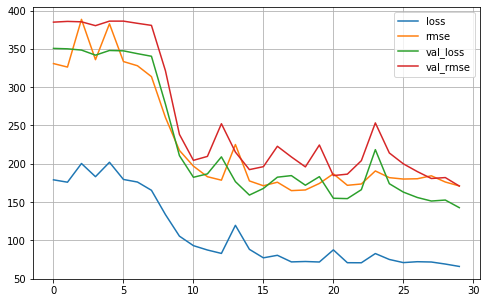

In [23]:
plot_train_history(unievo_hist, 'Training and validation loss')

In [24]:
unievo_test[1]

array([[147.        ,  97.        ,  64.        , ..., 410.        ,
        433.        , 443.        ],
       [ 97.        ,  64.        ,  46.        , ..., 433.        ,
        443.        , 446.        ],
       [ 64.        ,  46.        ,  68.        , ..., 443.        ,
        446.        , 430.        ],
       ...,
       [183.11764706, 150.        , 318.        , ..., 501.        ,
        475.        , 349.        ],
       [150.        , 318.        , 324.        , ..., 475.        ,
        349.        , 305.        ],
       [318.        , 324.        , 410.        , ..., 349.        ,
        305.        , 175.        ]])

In [25]:
save_performance_to_txt("Evo_Single_Variable",
                         unievo_model.predict(unievo_test[0]),
                         unievo_test[1], unievo_eval)

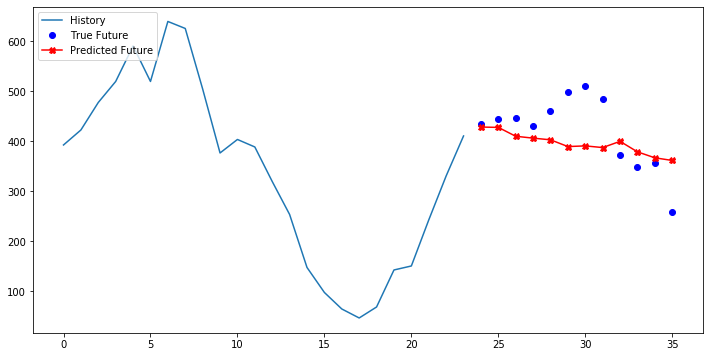

In [26]:
multi_step_plot(unievo_test[0][10], unievo_test[1][10], unievo_model.predict(np.array([unievo_test[0][10]])))

Evo Performance Univariavel (Hours Skiped = 12)


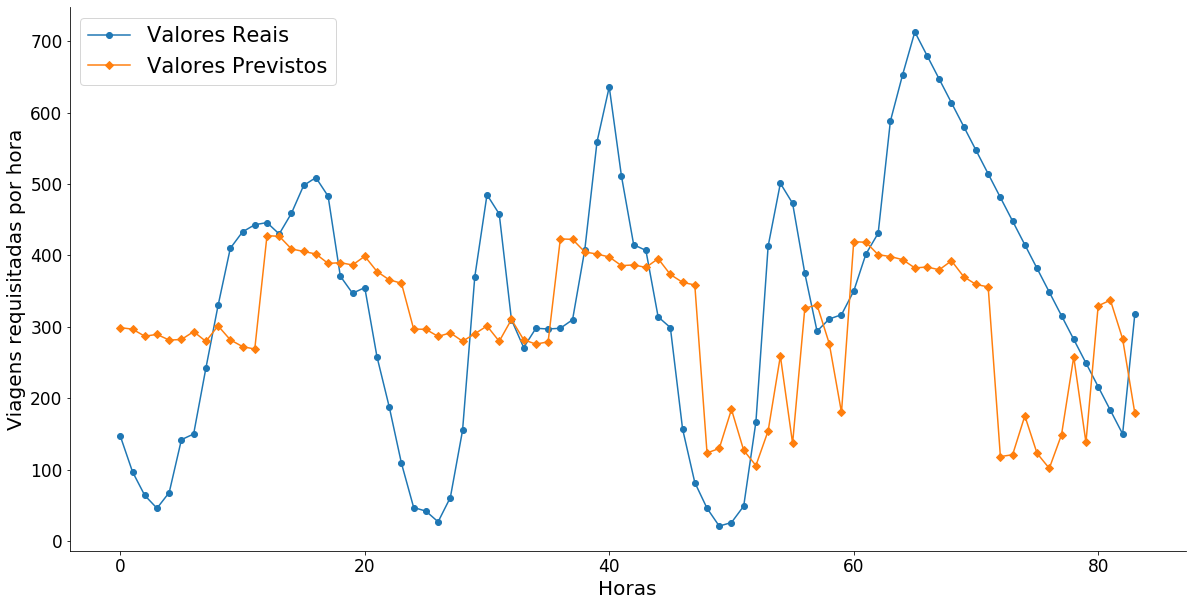

In [27]:
performance_representation_plot(12, 
                                "Evo Performance Univariavel",
                                unievo_model.predict(unievo_test[0]),
                                unievo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

### Multi Variable

In [28]:
print('Evo Model Multi Var')
evo_model, evo_hist, evo_test, evo_eval = run_lstm(evo_data,  24, 12, (0.6, 0.8), 120,
                                                   epochs=global_epoch_number, dropout=0.8, layer_count = 5)

Evo Model Multi Var
[252, 336]
[252, 336]
[252, 336]
(84, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 30s 602ms/step - loss: 152.5572 - rmse: 286.0124 - val_loss: 214.7813 - val_rmse: 239.6973
Epoch 2/30
50/50 [==============================] - 24s 480ms/step - loss: 111.8792 - rmse: 218.2019 - val_loss: 168.9317 - val_rmse: 189.5108
Epoch 3/30
50/50 [==============================] - 25s 497ms/step - loss: 93.5092 - rmse: 187.1857 - val_loss: 239.5588 - val_rmse: 275.8743
Epoch 4/30
50/50 [==============================] - 25s 495ms/step - loss: 82.9049 - rmse: 170.8215 - val_loss: 199.1674 - val_rmse: 227.2175
Epoch 5/30
50/50 [==============================] - 25s 502ms/step - loss: 74.2232 - rmse: 150.2307 - val_loss: 168.7381 - val_rmse: 194.4202
Epoch 6/30
50/50 [==============================] - 27s 538ms/step - loss: 73.8417 - rmse: 150.6845 - val_loss: 226.9602 - val_rmse: 264.8522
Epoch 7/30
50/50 [========================

In [29]:
evo_model.save(r'models/evo_model')

INFO:tensorflow:Assets written to: models/evo_model\assets


In [30]:
print(evo_eval)
print(eval_model(evo_test[1], persistance_model(evo_test[0], 12)))

{'RMSE': 125.97982133025837, 'MAE': 98.14011174685778, 'R2': 0.5269423641429092, 'MAPE': 0.48250206112878324}
{'RMSE': 378.5696999766747, 'MAE': 336.51984126984127, 'R2': -3.8022483262170965, 'MAPE': 0.9106317431136508}


### Plotting prediction

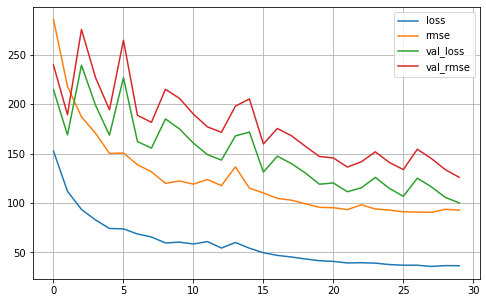

In [31]:
plot_train_history(evo_hist,
                   'Training and validation loss')

In [32]:
save_performance_to_txt("Evo_Multivariable",
                         evo_model.predict(evo_test[0]),
                         evo_test[1], evo_eval)


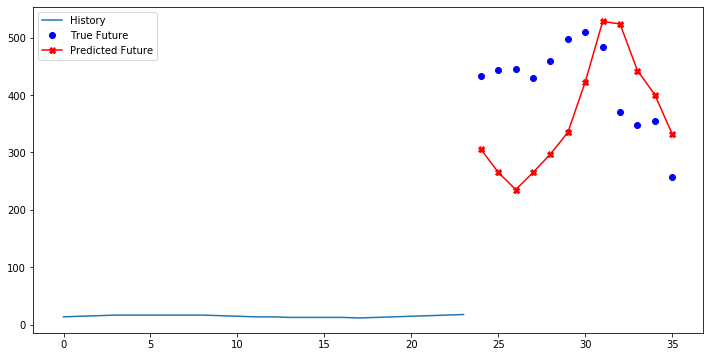

In [33]:
multi_step_plot(evo_test[0][10], evo_test[1][10], evo_model.predict(np.array([evo_test[0][10]])))

Evo Performance Multivariavel (Hours Skiped = 12)


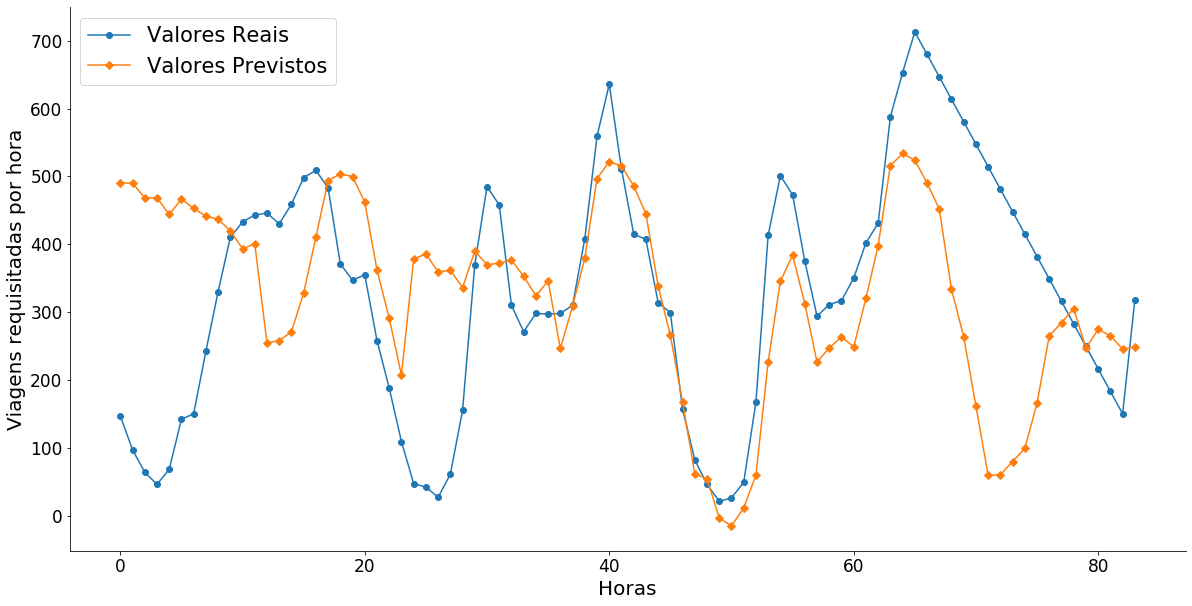

In [34]:
performance_representation_plot(12, 
                                "Evo Performance Multivariavel",
                                evo_model.predict(evo_test[0]),
                                evo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

## Modo model

### Single Variable

In [35]:
print('Modo Model')
unimodo_model, unimodo_hist, unimodo_test, unimodo_eval = run_lstm(unimodo_data, 24, 12, (0.6, 0.8), 60,
                                                          epochs=global_epoch_number, dropout=0.7, layer_count = 5)

Modo Model
[252, 336]
[252, 336]
[252, 336]
(84, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 23s 464ms/step - loss: 46.9324 - rmse: 67.8027 - val_loss: 32.5571 - val_rmse: 35.4078
Epoch 2/30
50/50 [==============================] - 17s 341ms/step - loss: 38.4892 - rmse: 62.3541 - val_loss: 19.5351 - val_rmse: 20.4408
Epoch 3/30
50/50 [==============================] - 16s 318ms/step - loss: 34.5266 - rmse: 60.6004 - val_loss: 15.9077 - val_rmse: 16.9765
Epoch 4/30
50/50 [==============================] - 16s 319ms/step - loss: 31.7728 - rmse: 59.5852 - val_loss: 18.4374 - val_rmse: 20.4307
Epoch 5/30
50/50 [==============================] - 16s 318ms/step - loss: 30.2228 - rmse: 58.9068 - val_loss: 14.8312 - val_rmse: 16.3846
Epoch 6/30
50/50 [==============================] - 16s 318ms/step - loss: 28.7505 - rmse: 57.9892 - val_loss: 13.2239 - val_rmse: 14.6195
Epoch 7/30
50/50 [==============================] - 16s 317ms/step - lo

In [36]:
unimodo_model.save(r'models/unimodo_model')

INFO:tensorflow:Assets written to: models/unimodo_model\assets


In [37]:
print(unimodo_eval)
print(eval_model(unimodo_test[1], persistance_model(unimodo_test[0], 12)))

{'RMSE': 9.19275068893433, 'MAE': 6.466026314255836, 'R2': 0.8762610904138087, 'MAPE': 0.35116885445290363}
{'RMSE': 45.28285949142343, 'MAE': 35.62132352941177, 'R2': -0.520081949869429, 'MAPE': 2.693530784221414}


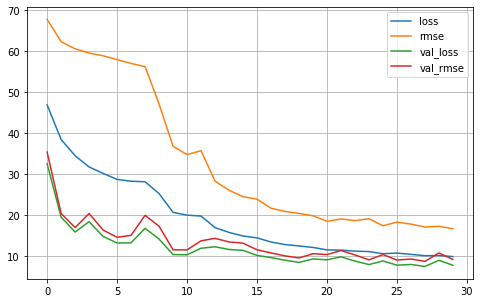

In [38]:
plot_train_history(unimodo_hist, 'Training and validation loss')

In [39]:
save_performance_to_txt("Modo_Single_Variable",
                         unimodo_model.predict(unimodo_test[0]),
                         unimodo_test[1], unimodo_eval)


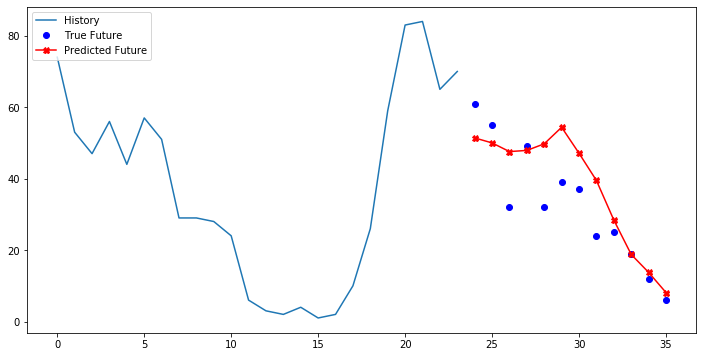

In [40]:
multi_step_plot(unimodo_test[0][10], unimodo_test[1][10], unimodo_model.predict(np.array([unimodo_test[0][10]])))

Modo Performance Univariavel (Hours Skiped = 12)


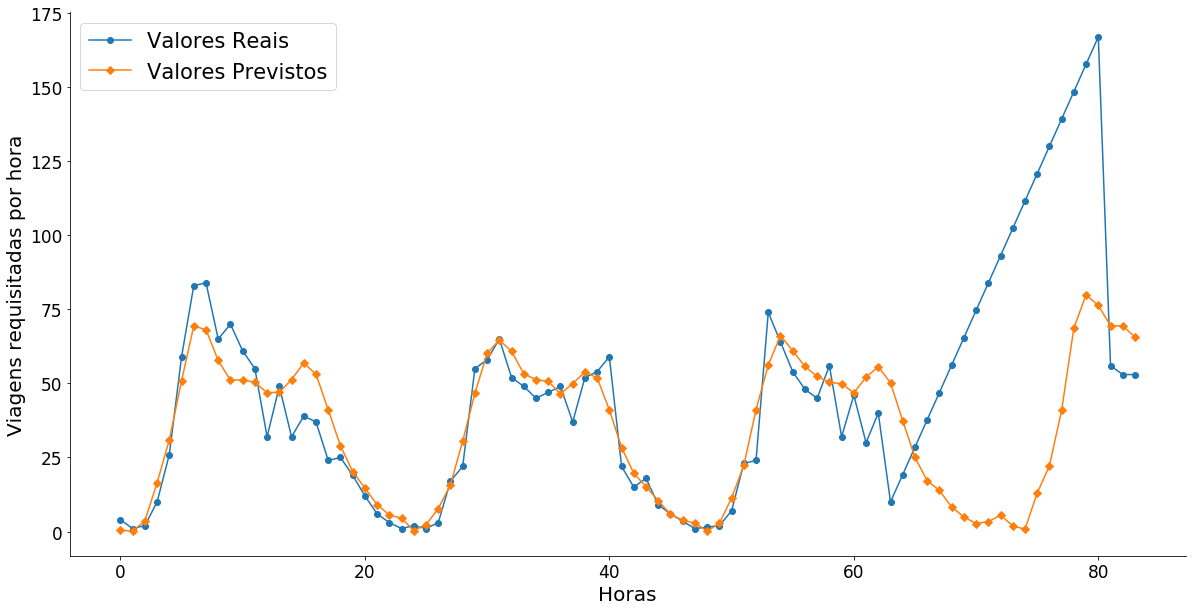

In [41]:
performance_representation_plot(12, 
                                "Modo Performance Univariavel",
                                unimodo_model.predict(unimodo_test[0]),
                                unimodo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

### Multi Variable

In [42]:
print('Modo Model')
modo_model, modo_hist, modo_test, modo_eval = run_lstm(modo_data, 24, 12, (0.6, 0.8), 120,
                                                       epochs=global_epoch_number, dropout=0.8, layer_count = 5)

Modo Model
[252, 336]
[252, 336]
[252, 336]
(84, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 40s 806ms/step - loss: 61.4393 - rmse: 76.8817 - val_loss: 31.1522 - val_rmse: 25.4816
Epoch 2/30
50/50 [==============================] - 34s 677ms/step - loss: 55.2569 - rmse: 71.6401 - val_loss: 28.4758 - val_rmse: 24.0473
Epoch 3/30
50/50 [==============================] - 35s 690ms/step - loss: 51.3790 - rmse: 68.4747 - val_loss: 35.8641 - val_rmse: 35.5549
Epoch 4/30
50/50 [==============================] - 35s 693ms/step - loss: 38.8093 - rmse: 54.7031 - val_loss: 24.6366 - val_rmse: 23.2150
Epoch 5/30
50/50 [==============================] - 35s 693ms/step - loss: 31.1061 - rmse: 46.0443 - val_loss: 28.3377 - val_rmse: 29.0147
Epoch 6/30
50/50 [==============================] - 36s 716ms/step - loss: 25.1887 - rmse: 40.1370 - val_loss: 22.5552 - val_rmse: 23.1423
Epoch 7/30
50/50 [==============================] - 35s 706ms/step - lo

In [43]:
modo_model.save(r'models/modo_model')

INFO:tensorflow:Assets written to: models/modo_model\assets


In [44]:
print(modo_eval)
print(eval_model(modo_test[1], persistance_model(modo_test[0], 12)))

{'RMSE': 26.475070368610062, 'MAE': 11.020344279213717, 'R2': -0.0329836500291587, 'MAPE': 1.34747152542564}
{'RMSE': 48.498652964823954, 'MAE': 35.53670634920635, 'R2': -0.7303016958232833, 'MAPE': 1.6767322879225275}


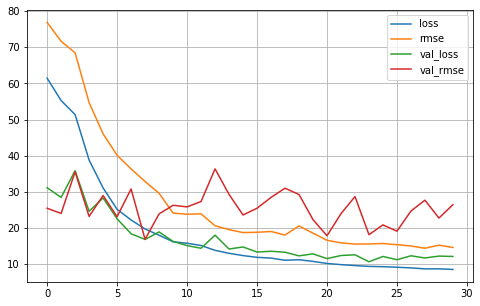

In [45]:
plot_train_history(modo_hist,
                   'Training and validation loss')

In [46]:
save_performance_to_txt("Modo_Multivariable",
                         modo_model.predict(modo_test[0]),
                         modo_test[1], modo_eval)


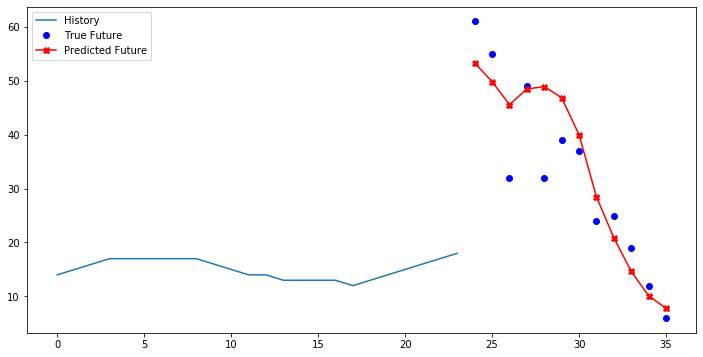

In [47]:
multi_step_plot(modo_test[0][10], modo_test[1][10], modo_model.predict(np.array([modo_test[0][10]])))

Modo Performance Multivariavel (Hours Skiped = 12)


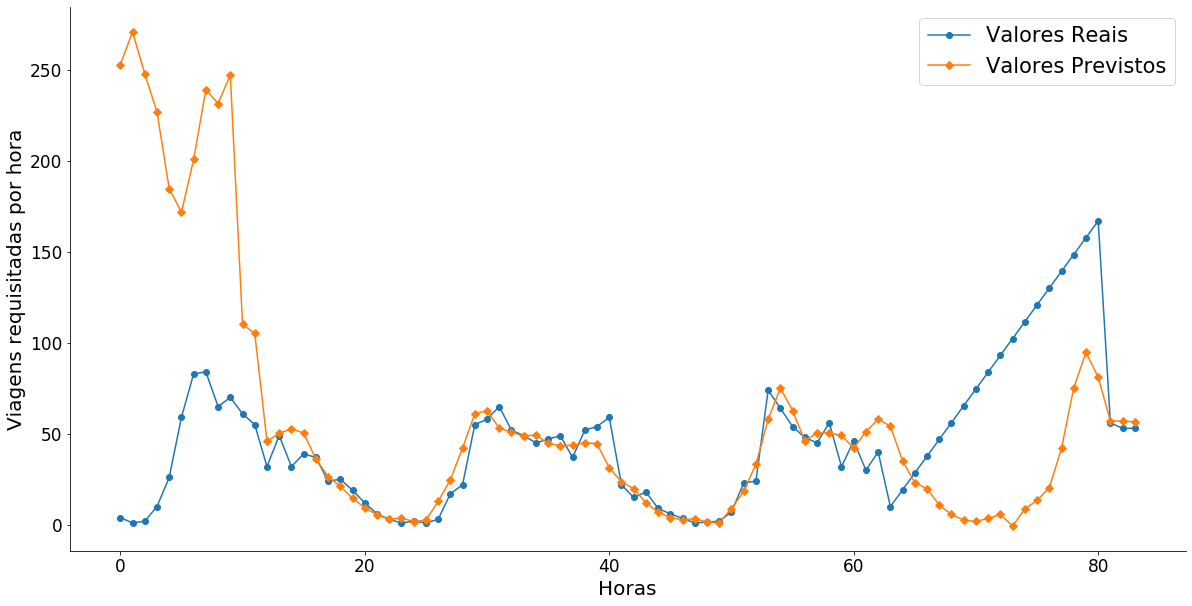

In [48]:
performance_representation_plot(12, 
                                "Modo Performance Multivariavel",
                                modo_model.predict(modo_test[0]),
                                modo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

## Car2Go Model

### Single Variable

In [49]:
print('Car2Go Model')
unic2g_model, unic2g_hist, unic2g_test, unic2g_eval = run_lstm(unic2g_data, 24, 12, (0.6, 0.8), 60,
                                                               epochs=global_epoch_number, dropout=0.7, layer_count = 5)

Car2Go Model
[252, 336]
[252, 336]
[252, 336]
(84, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 38s 752ms/step - loss: 134.5499 - rmse: 155.8921 - val_loss: 104.7198 - val_rmse: 120.9491
Epoch 2/30
50/50 [==============================] - 20s 405ms/step - loss: 108.3491 - rmse: 124.3271 - val_loss: 130.0350 - val_rmse: 149.3964
Epoch 3/30
50/50 [==============================] - 33s 657ms/step - loss: 101.9802 - rmse: 117.3737 - val_loss: 113.8909 - val_rmse: 131.7682
Epoch 4/30
50/50 [==============================] - 31s 612ms/step - loss: 95.1491 - rmse: 110.0312 - val_loss: 89.7959 - val_rmse: 107.0749
Epoch 5/30
50/50 [==============================] - 21s 415ms/step - loss: 85.5266 - rmse: 100.3693 - val_loss: 111.9989 - val_rmse: 133.6518
Epoch 6/30
50/50 [==============================] - 20s 400ms/step - loss: 72.8182 - rmse: 89.0788 - val_loss: 97.4366 - val_rmse: 118.9341
Epoch 7/30
50/50 [==============================] -

In [50]:
unic2g_model.save(r'models/unic2g_model')

INFO:tensorflow:Assets written to: models/unic2g_model\assets


In [51]:
print(unic2g_eval)
print(eval_model(unic2g_test[1], persistance_model(unic2g_test[0], 12)))

{'RMSE': 57.01427679092648, 'MAE': 41.22864185060774, 'R2': 0.7484023222548978, 'MAPE': 0.2841733351913538}
{'RMSE': 152.19682653700934, 'MAE': 124.68948412698411, 'R2': -1.2346068267182237, 'MAPE': 2.057604807380699}


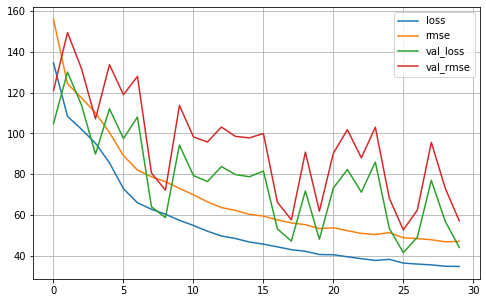

In [52]:
plot_train_history(unic2g_hist,
                   'Training and validation loss')

In [53]:
save_performance_to_txt("Car2Go_Single_Variable",
                         unic2g_model.predict(unic2g_test[0]),
                         unic2g_test[1], unic2g_eval)

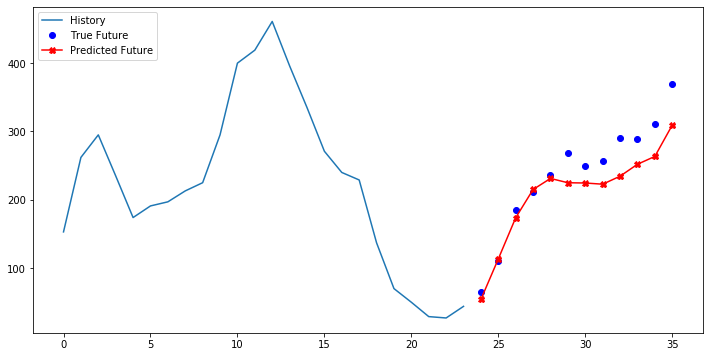

In [54]:
multi_step_plot(unic2g_test[0][10], unic2g_test[1][10], unic2g_model.predict(np.array([unic2g_test[0][10]])))

Car2Go Performance Univariável (Hours Skiped = 12)


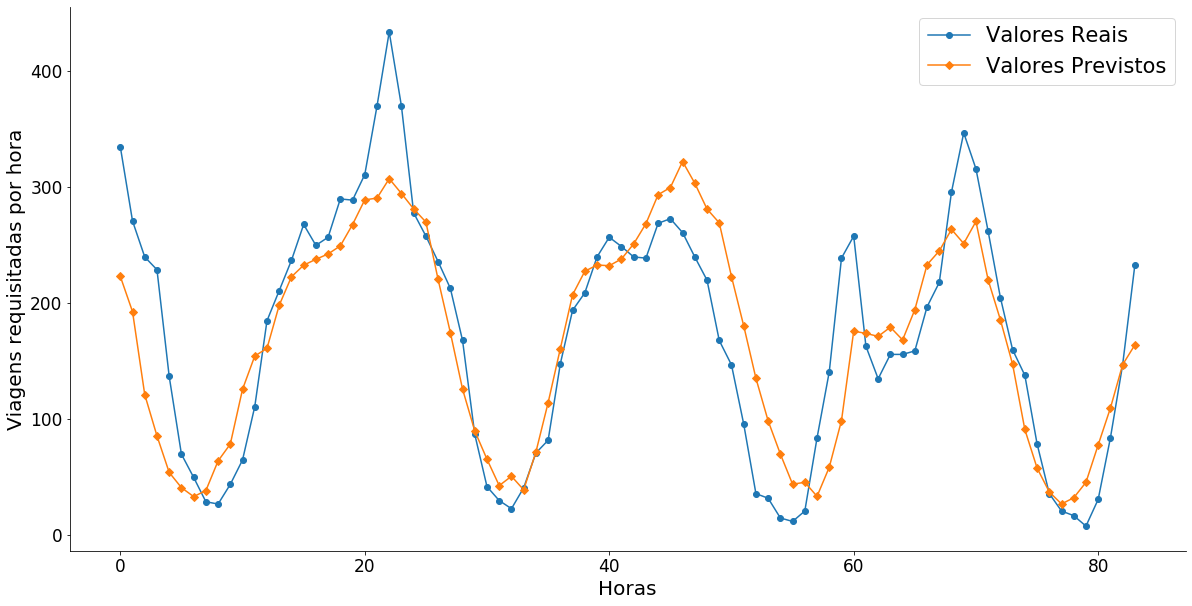

In [55]:
performance_representation_plot(12, 
                                "Car2Go Performance Univariável",
                                unic2g_model.predict(unic2g_test[0]),
                                unic2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

### Multi Variable

In [56]:
print('Car2Go Model')
c2g_model, c2g_hist, c2g_test, c2g_eval = run_lstm(c2g_data, 24, 12, (0.6, 0.8), 120,
                                                   epochs=global_epoch_number, dropout=0.8, layer_count = 5)

Car2Go Model
[252, 336]
[252, 336]
[252, 336]
(84, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 57s 1s/step - loss: 1906.5626 - rmse: 2467.5884 - val_loss: 154.4372 - val_rmse: 175.5552
Epoch 2/30
50/50 [==============================] - 53s 1s/step - loss: 119.1605 - rmse: 130.6898 - val_loss: 117.6217 - val_rmse: 130.1119
Epoch 3/30
50/50 [==============================] - 55s 1s/step - loss: 357.3243 - rmse: 447.0205 - val_loss: 172.1738 - val_rmse: 192.3154
Epoch 4/30
50/50 [==============================] - 57s 1s/step - loss: 134.4912 - rmse: 153.6519 - val_loss: 181.3471 - val_rmse: 202.5775
Epoch 5/30
50/50 [==============================] - 58s 1s/step - loss: 113.5103 - rmse: 127.6996 - val_loss: 145.5294 - val_rmse: 167.0219
Epoch 6/30
50/50 [==============================] - 58s 1s/step - loss: 104.5047 - rmse: 118.7281 - val_loss: 121.8567 - val_rmse: 143.0575
Epoch 7/30
50/50 [==============================] - 58s 1s/st

In [57]:
c2g_model.save(r'models/c2g_model')

INFO:tensorflow:Assets written to: models/c2g_model\assets


In [58]:
print(c2g_eval)
print(eval_model(c2g_test[1], persistance_model(c2g_test[0], 12)))

{'RMSE': 103.883428003314, 'MAE': 68.48023213363355, 'R2': 0.16406691494972148, 'MAPE': 0.4169908760325335}
{'RMSE': 189.31169969882248, 'MAE': 160.18353174603175, 'R2': -2.4292549887716572, 'MAPE': 0.8319814758908036}


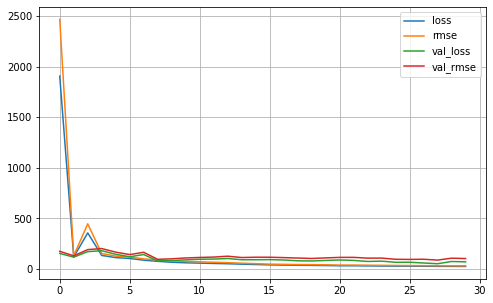

In [59]:
plot_train_history(c2g_hist, 'Training and validation loss')

In [60]:
save_performance_to_txt("Car2Go_Multivariable",
                         c2g_model.predict(c2g_test[0]),
                         c2g_test[1], c2g_eval)

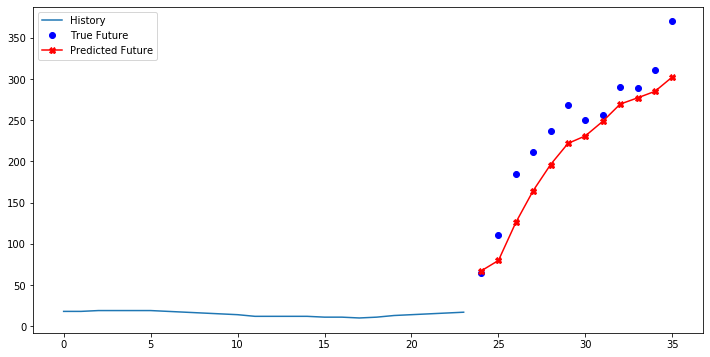

In [61]:
multi_step_plot(c2g_test[0][10], c2g_test[1][10], c2g_model.predict(np.array([c2g_test[0][10]])))

Car2Go Performance Multivariavel (Hours Skiped = 12)


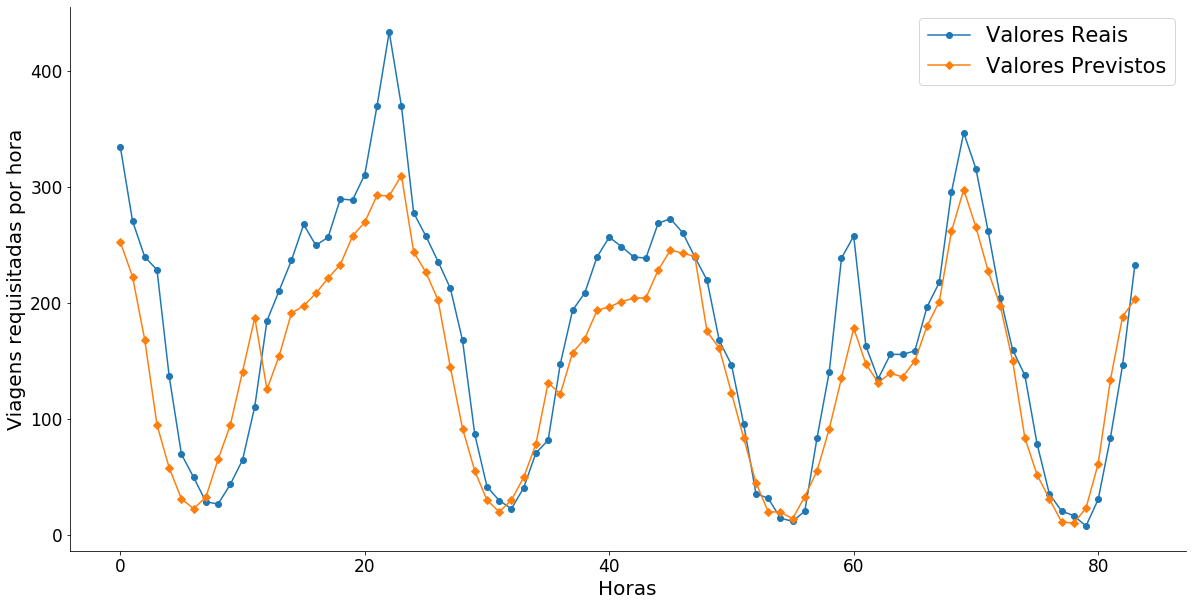

In [62]:
performance_representation_plot(12, 
                                "Car2Go Performance Multivariavel",
                                c2g_model.predict(c2g_test[0]),
                                c2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

## Comparison Tables

In [63]:
evo_table = pd.DataFrame(data={"uni":unievo_eval, "multi":evo_eval})


performance_representation_plotrences

* https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series
* http://netlab.ice.ufjf.br/index.php/carsharingdata/